In summary, here is the current state of the problem as indicated by this notebook:
* The interpolate_cell function returns a best_z which is significantly different from the "answer" (zero)
    should be zero but is about 0.08
* We get this answer by first computing the sigma12 associated with model0 at redshift zero and omegu_nuh2=0.002
* We've confirmed that this z discrepancy is ENTIRELY responsible for the differences in the errors, because
    we have gone back and forced the two approaches to use the same redshift value.

In [1]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

regenerate = True

pb.ion()

file_base = ""

In [2]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

In [3]:
# Technically what we really wanted was hc_G6, but I really don't want to re-run the emu builder
# right now. hc_G3_redo should be close enough
X_raw = np.load("../hc_G3_redo.npy", allow_pickle=True)

In [4]:
scales = np.load("../standard_k.npy", allow_pickle=True)

In [5]:
test_omnuh2 = 0.002

m0_without_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], 0, 0)
m0_with_neuts = ci.specify_neutrino_mass(ci.cosm.iloc[0], test_omnuh2, 1)

m0_with_neuts['omch2'] -= test_omnuh2

In [25]:
# We'll need to check our work using CAMB
p_true_interpolator = ci.andrea_interpolator(m0_with_neuts)
p_true_MEMNeC_interpolator = ci.andrea_interpolator(m0_without_neuts)

nnu_massive: 1
nnu_massive: 0


In [8]:
p_m0truth = np.array([p_true_interpolator.P(0, k) for k in scales])

In [26]:
# We want the sigma12 value that we would get from the MEMNeC interpolator...

s_m0truth = ci.s12_from_interpolator(p_true_MEMNeC_interpolator, 0)

m0_without_neuts['sigma12'] = m0_with_neuts['sigma12'] = s_m0truth

print(s_m0truth)

0.8247367108849203


In [ ]:
p_m0truth2, actual_sigma12, rescale_params = ged.interpolate_cell(m0_with_neuts, scales)

nnu_massive: 0
nnu_massive: 1


In [ ]:
best_z = rescale_params[1]
print(actual_sigma12)
print(best_z)

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

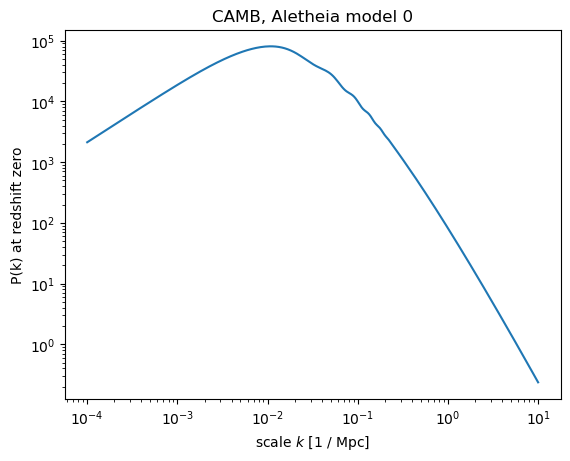

In [12]:
#import matplotlib.pyplot as plt
pb.loglog(scales, p_m0truth)
pb.title("CAMB, Aletheia model 0")
pb.ylabel('P(k) at redshift zero')
pb.xlabel('scale $k$ [1 / Mpc]')

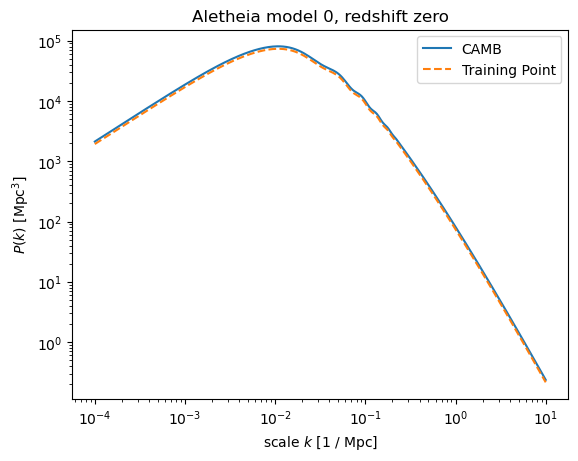

In [13]:
pb.loglog(scales, p_m0truth, label="CAMB")
pb.loglog(scales, p_m0truth2, label="Training Point", linestyle='dashed')
pb.title("Aletheia model 0, redshift zero")
pb.ylabel('$P(k)$ [Mpc$^3$]')
pb.xlabel('scale $k$ [1 / Mpc]')
pb.legend()

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

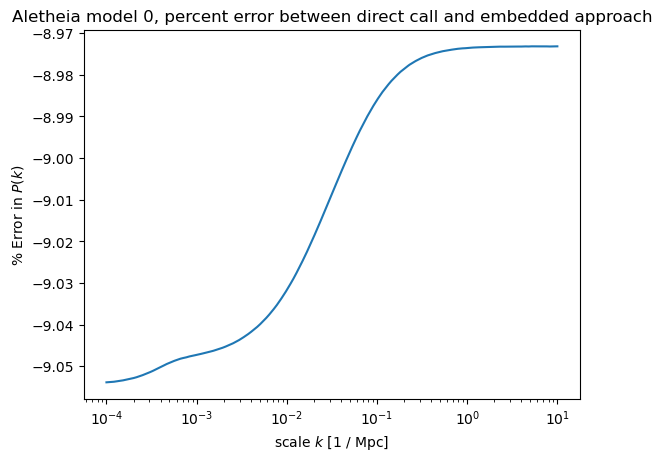

In [14]:
pb.plot(scales,
    (p_m0truth2 - p_m0truth) / p_m0truth * 100)
pb.xscale('log')
pb.title("Aletheia model 0, percent error between direct call and embedded approach")
pb.ylabel('% Error in $P(k)$')
pb.xlabel('scale $k$ [1 / Mpc]')
# pb.savefig("../../plots/emulator/performance/massive_m0_G5.png")

In [18]:
_redshifts=np.flip(np.linspace(0, 10, 150))

MEMNeC_p_interpolator = \
    ci.andrea_interpolator(
        m0_without_neuts)#, redshifts=_redshifts, kmax=10)
list_sigma12 = np.array([
    ci.s12_from_interpolator(MEMNeC_p_interpolator, z) for z in _redshifts
])

nnu_massive: 0


In [27]:
print("Our goal is a sigma12 of:", m0_with_neuts["sigma12"])
print(np.flip(list_sigma12))

Our goal is a sigma12 of: 0.8247367108849203
[0.82473671 0.7957747  0.76770081 0.74061989 0.71460169 0.68968628
 0.66588939 0.64320736 0.62162167 0.60110267 0.58161287 0.5631095
 0.54554663 0.52887679 0.51305212 0.49802538 0.48375053 0.47018321
 0.45728104 0.44500375 0.4333133  0.42217388 0.4115519  0.40141591
 0.39173649 0.38248622 0.3736395  0.36517247 0.35706293 0.34929016
 0.34183489 0.33467914 0.32780618 0.3212004  0.31484721 0.30873305
 0.30284522 0.29717185 0.29170188 0.28642492 0.28133127 0.27641182
 0.27165805 0.26706196 0.26261603 0.2583132  0.25414684 0.25011069
 0.24619889 0.24240587 0.23872642 0.23515561 0.23168879 0.22832154
 0.22504971 0.22186936 0.21877676 0.21576839 0.21284089 0.20999109
 0.20721597 0.20451268 0.20187848 0.1993108  0.19680718 0.19436526
 0.19198283 0.18965774 0.18738799 0.18517162 0.18300679 0.18089176
 0.17882481 0.17680436 0.17482886 0.17289683 0.17100687 0.16915762
 0.1673478  0.16557617 0.16384153 0.16214274 0.16047871 0.1588484
 0.15725079 0.15568

In [22]:
from scipy.interpolate import interp1d
interpolator = interp1d(np.flip(list_sigma12), np.flip(_redshifts),
        kind='cubic')

z_best = interpolator(m0_with_neuts["sigma12"])

z_best

array(0.08893258)